# sequence prediction sandbox


In [1]:
import torch
from torch.utils.data import TensorDataset,DataLoader
from torch import nn

import logomaker
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7) #10

import utils as u

## Load data 

In [2]:
def load_data(
        upstream_region_file,
        data_mat_file, 
        sample2cond_file, 
        sample_file, 
        condition_file,
        coded_meta_file
        ):
    '''
    Wrapper function to load data from files into relavent objects
    '''
    # load upstream seq regions
    seqs = u.load_promoter_seqs(upstream_region_file)
    loc2seq = dict([(x,z) for (x,y,z) in seqs])
    
    # load TPM data
    tpm_df = pd.read_csv(data_mat_file,sep='\t').fillna('')

    
    # load mapping from sample to condition
    with open(sample2cond_file,'r') as f:
        sample2condition = dict(x.strip().split() for x in f.readlines())

    
    # load sample to include file
    if sample_file:
        with open(sample_file,'r') as f:
            samples = list(x.strip() for x in f.readlines())
    # if none provided, just use all the samples from the sample2condition dict
    else: 
        samples = list(sample2condition.keys())

        
    # load the conditions to include file
    if condition_file:
        with open(condition_file,'r') as f:
            conditions = list(x.strip() for x in f.readlines())
    # if none provided, just use all the conditions
    else:
        conditions = list(set([sample2condition[x] for x in sample2condition]))

    # load coded metadata file
    meta_df = pd.read_csv(coded_meta_file,sep='\t')
    meta_df['sample'] = meta_df['#sample']+'_tpm'

    return loc2seq, tpm_df, sample2condition, samples, conditions, meta_df

In [3]:
upstream_region_file = 'all_seq_info/all_loci_upstream_regions_w100_min20.fa'
data_mat_file = 'data/extract_TPM_counts.tsv'
sample2cond_file = 'data/sample2condition.txt'
sample_file = None
condition_file = 'data/conditions_to_include.txt'
coded_meta_file = 'data/5G_exp_metadata_coded.tsv'
COND_COLS = ['carbon_source','oxygen_level','nitrate_level','copper_level','lanthanum_level','growth_rate','growth_mode']


loc2seq, tpm_df, sample2condition, samples, conditions, meta_df = load_data(
    upstream_region_file,
    data_mat_file, 
    sample2cond_file, 
    sample_file, 
    condition_file,
    coded_meta_file
)

In [4]:
def format_XY_dfs(tpm_df, meta_df):
    # melt tpm df so every sample is in a row
    tpm_melt = tpm_df[['locus_tag']+samples].melt(id_vars=['locus_tag'],var_name='sample',value_name='tpm')
    tpm_melt['condition'] = tpm_melt['sample'].apply(lambda x: sample2condition[x])

    # also add in upstream seq
    tpm_melt['upstream_region'] = tpm_melt['locus_tag'].apply(lambda x: loc2seq[x])
    
    # get coded metadata conditions from meta_df
    samp2cond_df = meta_df[['sample']+COND_COLS]

    # merge back onto the tpm df
    df = tpm_melt.merge(samp2cond_df,on='sample',how='left')
    
    # reformat full df
    full_df = df[['locus_tag','upstream_region', 'sample','condition']+COND_COLS+['tpm']]
    
    # separate out just X (features) and Y (labels)
    X = full_df[['locus_tag','upstream_region']+COND_COLS]
    Y = full_df['tpm']
    
    return full_df,X,Y
    

In [5]:
full_df, X, Y = format_XY_dfs(tpm_df,meta_df)

In [6]:
full_df

,locus_tag,upstream_region,sample,condition,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,tpm
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,2.933003
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.607784
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.415515
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,3.200081
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.522728
...,...,...,...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,24.508375
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,130.851229
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,66.415222
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,164.123473


In [7]:
X

,locus_tag,upstream_region,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,2,0,0,3,0,0,0
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,2,0,0,3,0,0,0
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,2,0,0,3,0,0,0
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,2,0,0,3,0,0,0
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,2,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,2,1,0,3,0,2,1
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,2,1,0,3,0,2,1
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,2,1,0,3,0,2,1
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,2,1,0,3,0,2,1


In [8]:
Y

0           2.933003
1           1.607784
2           1.415515
3           3.200081
4           1.522728
             ...    
412869     24.508375
412870    130.851229
412871     66.415222
412872    164.123473
412873    301.751157
Name: tpm, Length: 412874, dtype: float64

In [9]:
def one_hot_encode(seq):
    #print("one hot encoding...")
    
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Creat empty matrix.
    #vec=torch.tensor([nuc_d[x] for x in seq])
    vec=np.array([nuc_d[x] for x in seq]).flatten()
        
    return vec

In [10]:
#tl_lin, vl_lin = fit(50, model_lin, loss_func, optimizer, train_dl, test_dl)

In [11]:
def quick_load_and_split_input(data, split_frac=0.8, verbose=False):
    '''
    Given a list of tuples, build a df, ohe the sequences, and randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    
    Return pytorch tensors of x/y train/test
    '''
    # convert data to df and one-hot encode
    df = pd.DataFrame(data, columns = ['seq','score'])
    df['oh'] = df['seq'].apply(lambda x: one_hot_encode(x))

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]

    x_train = torch.tensor(list(train_df['oh'].values))
    y_train = torch.tensor(list(train_df['score'].values)).unsqueeze(1)
    x_test  = torch.tensor(list(test_df['oh'].values))
    y_test  = torch.tensor(list(test_df['score'].values)).unsqueeze(1)
    
    if verbose:
        print("Example train seq")
        plt.imshow(x_train[0].reshape((6, 4)), cmap="gray")
        plt.show()
        
        print(idxs)
        print("Train #:", len(train_idxs))
        print("Test #:", len(test_idxs))
        
        print("Y test:", y_test)
        
    return x_train, y_train, x_test, y_test

def build_dataloaders(data, batch_size=4):
    '''
    Given sets of x and y train and test, put into pytorch loaders
    '''
    x_train, y_train, x_test, y_test = quick_load_and_split_input(data, verbose=True)
    
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_ds = TensorDataset(x_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
    return train_dl, test_dl

In [12]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    loss = loss_func(model(xb.float()), yb.float())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [13]:
class DNA_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(24, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        return self.lin(xb)
    

    
class DNA_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        xb = xb.view(-1,6,4).permute(0,2,1) # reshape to 4bs x 4channel x 6len
        #print(xb)
        xb = self.conv_net(xb)
        return xb

In [14]:
def run_model(train_dl,test_dl, model, lr=0.01, epochs=50):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, val_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    return model, train_losses, val_losses


def run_linear_model(train_dl,test_dl, lr=0.01, epochs=50):
    '''Linear specific model runner'''
    model = DNA_Linear()
    
    return run_model(train_dl,test_dl, model)


def run_cnn_model(train_dl,test_dl, lr=0.01, epochs=50):
    '''CNN specific model runner'''
    model = DNA_CNN()
    return run_model(train_dl,test_dl, model)

In [15]:
def quick_loss_plot(data_label):
    '''Plot loss by epoch'''
    for data, label in data_label:
        plt.plot(data, label=label)
    plt.legend()
    plt.ylabel("MSE loss")
    plt.xlabel("Epoch")
    plt.show()
    
def quick_seq_pred(model, seqs):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna))
        pred = model(s.float())
        print(dna, pred.item())

## Fake data

Example train seq


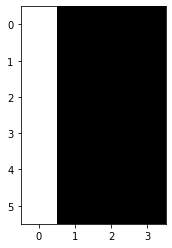

[22, 35, 14, 15, 10, 44, 11, 16, 43, 26, 38, 40, 31, 8, 0, 21, 19, 12, 24, 37, 45, 28, 36, 18, 1, 30, 17, 29, 7, 33, 39, 27, 5, 2, 13, 32, 42, 23, 6, 34, 4, 3, 41, 25, 9, 20]
Train #: 36
Test #: 10
Y test: tensor([[8.0000],
        [7.0000],
        [6.7000],
        [4.0000],
        [9.9000],
        [7.8000],
        [6.6000],
        [1.1000],
        [1.1000],
        [1.1000]], dtype=torch.float64)


In [16]:
# mostly A = 10.0
# mostly C = 7.0
# mostly G = 4.0
# mostly T = 1.0
data = [
    ('AAAAAA', 10.0),
    ('ATAAAA', 9.0),
    ('AAAACA', 9.8),
    ('CCAACA', 8.0),
    ('CCCCCC', 7.0),
    ('CGGACC', 6.8),
    ('CCCGCC', 6.7),
    ('GGGACG', 6.2),
    ('CGGGCG', 5.0),
    ('GGGGGG', 4.0),
    ('GCCGGT', 4.1),
    ('TGGTGT', 3.0),
    ('CGGTTG', 3.4),
    ('TTGTGT', 2.0),
    ('TTTTTT', 1.0),
    ('TAATTA', 5.1),
    ('GAGTGA', 5.3),
    ('AAATAA', 9.1),
    ('AAAAAG', 9.4),
    ('TTAGCT', 3.2),
    ('CAAAAA', 9.9),
    ('ACAAAA', 9.8),
    ('AAAACA', 9.8),
    ('CCAATA', 7.8),
    ('CCCGCC', 6.8),
    ('CGGATC', 6.6),
    ('CACGCC', 6.9),
    ('AGGACG', 6.5),
    ('CGTGCG', 4.9),
    ('GGGGGA', 4.3),
    ('GCCGGA', 4.5),
    ('TGGTGA', 3.5),
    ('CGGTTA', 3.8),
    ('TTGTGA', 2.5),
    ('TTTTTG', 1.1),
    ('TAATAA', 5.6),
    ('GAGTGC', 5.0),
    ('AAATAC', 8.7),
    ('AACAAA', 9.9),
    ('TTCTTT', 1.3),
    ('TTTCTT', 1.2),
    ('TTTTGT', 1.1),
    ('GTTTTT', 1.1),
    ('AACAAA', 9.8),
    ('AAAAGA', 9.7),
    ('TAAAAA', 9.4),
]
train_dl, test_dl = build_dataloaders(data)

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 16.04424720928073
1 8.246051836013795
2 5.015279722213745
3 3.504280948638916
4 2.6904932498931884
5 2.1938068151473997
6 1.8582923412322998
7 1.610956859588623
8 1.4282274007797242
9 1.2855990409851075
10 1.1751596331596375
11 1.075562310218811
12 0.9930470824241638
13 0.9308230578899384
14 0.8704808115959167
15 0.824708741903305
16 0.7842050492763519
17 0.744807368516922
18 0.7147277772426606
19 0.681810712814331
20 0.6536292433738708
21 0.6284687995910645
22 0.6075228571891784
23 0.5891503632068634
24 0.5773628711700439
25 0.561837887763977
26 0.5411929607391357
27 0.5282421052455902
28 0.5163048148155213
29 0.5093129634857178
30 0.499590802192688
31 0.4889539808034897
32 0.4769159972667694
33 0.4691132128238678
34 0.4640415281057358
35 0.45919847786426543
36 0.4515656352043152
37 0.4442364573478699
38 0.4378489077091217
39 0.42972089648246764
40 0.42701354026794436
41 0.42142178416252135
42 0.41613117456436155
43 0.4130092740058899
44 0.40685602426528933
45 0.4036281943321228
46 

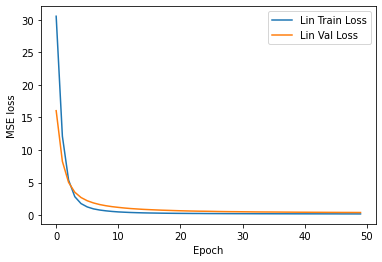

In [17]:
model_lin, tl_lin, vl_lin = run_linear_model(train_dl, test_dl)

# to plot loss
lin_data_label = list(zip([tl_lin,vl_lin], ['Lin Train Loss','Lin Val Loss']))
quick_loss_plot(lin_data_label)

In [18]:
seqs1 = ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]
seqs2 = ['TATAAA', 'TAATAT','CCTATA','AAGCGA','GCGAAA','TTGCGA','GCGTAA', 'TATTAA','TTTATT']

quick_seq_pred(model_lin, seqs1)
print()
quick_seq_pred(model_lin, seqs2)

AAAAAA 10.432929992675781
CCCCCC 5.807034492492676
GGGGGG 3.761687755584717
TTTTTT 0.9597384929656982
AACCAA 8.030889511108398
CCGGGG 4.4118547439575195
GGGTAA 5.416774749755859
TTTCGT 1.4795384407043457
TGTAAT 4.983198165893555

TATAAA 7.215723991394043
TAATAT 5.5928754806518555
CCTATA 5.855916500091553
AAGCGA 6.4058732986450195
GCGAAA 7.393917083740234
TTGCGA 2.894666910171509
GCGTAA 5.627690315246582
TATTAA 5.449496746063232
TTTATT 2.725965976715088


# Next with specific patterns that mean higher score

Example train seq


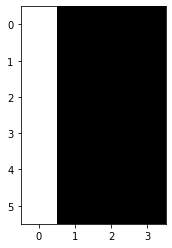

[8, 28, 43, 11, 21, 44, 37, 1, 0, 47, 26, 32, 38, 12, 17, 40, 42, 30, 33, 14, 10, 41, 16, 9, 18, 2, 7, 24, 22, 5, 25, 15, 19, 48, 46, 29, 20, 27, 34, 31, 13, 39, 3, 36, 4, 45, 35, 6, 23]
Train #: 39
Test #: 10
Y test: tensor([[14.8000],
        [ 9.0000],
        [ 0.4000],
        [ 4.1000],
        [ 9.9000],
        [ 0.3000],
        [13.9000],
        [ 0.2000],
        [ 5.0000],
        [ 1.1000]], dtype=torch.float64)


In [19]:
# fake data: 
# TAT = really high: >13.0 (10 examples)
# GCG = really low:  < 1.0 (10 examples)
data2 = [
    ('AAAAAA', 10.0),
    ('AATATA', 15.0),
    ('TATAAA', 14.9),
    ('TAATAT', 14.8),
    ('ATAAAA', 9.0),
    ('AAAACA', 9.8),
    ('GCGACA', 0.4),
    ('CCCCCC', 7.0),
    ('CGGACC', 6.8),
    ('CTATCC', 13.6),
    ('GGGACG', 6.2),
    ('CGGGCG', 0.5),
    ('GGGGGG', 4.0),
    ('GCCGGT', 4.1),
    ('TGTATT', 12.3),
    ('CGGTTG', 3.4),
    ('TTGCGT', 0.1),
    ('TTTTTT', 1.0),
    ('TAATTA', 5.1),
    ('GAGTGA', 5.3),
    ('AAATAT', 14.9),
    ('AAGCGA', 0.5),
    ('TTAGCT', 3.2),
    ('CAAAAA', 9.9),
    ('ACAAAA', 9.8),
    ('AAAACA', 9.8),
    ('CCTATA', 14.5),
    ('CCCGCC', 6.8),
    ('CGGATC', 6.6),
    ('CACGCG', 0.3),
    ('AGGACG', 6.5),
    ('CGTGCG', 0.3),
    ('GGGGGA', 4.3),
    ('GCCGGA', 4.5),
    ('TGGTGA', 3.5),
    ('CGGTAT', 13.9),
    ('TTGCGA', 0.2),
    ('TTTTTG', 1.1),
    ('TATTAA', 14.7),
    ('GAGTGC', 5.0),
    ('AAATAC', 8.7),
    ('AGCGAA', 0.6),
    ('TTCTTT', 1.3),
    ('TTTATT', 13.6),
    ('TTTTGT', 1.1),
    ('GTTTTT', 1.1),
    ('AACAAA', 9.8),
    ('AAGCGA', 0.6),
    ('GCGAAA', 0.7),
]

train_dl2, test_dl2 = build_dataloaders(data2)

### Linear model

In [20]:
model_lin2, tl_lin2, vl_lin2 = run_linear_model(train_dl2, test_dl2)

quick_seq_pred(model_lin2, seqs1)
print()
quick_seq_pred(model_lin2, seqs2)

0 36.94063639640808
1 27.927368927001954
2 24.87307834625244
3 23.738344955444337
4 23.15058078765869
5 22.853421020507813
6 22.662092781066896
7 22.55290870666504
8 22.542359352111816
9 22.483947372436525
10 22.53341178894043
11 22.502030181884766
12 22.611562728881836
13 22.658489799499513
14 22.741906356811523
15 22.775083160400392
16 22.898284721374512
17 23.012108612060548
18 23.08958969116211
19 23.195694541931154
20 23.24486846923828
21 23.318139266967773
22 23.3701810836792
23 23.47089080810547
24 23.49273796081543
25 23.446234130859374
26 23.46485137939453
27 23.484292221069335
28 23.537090301513672
29 23.690419006347657
30 23.656224060058594
31 23.731111526489258
32 23.77266960144043
33 23.84224853515625
34 23.88177833557129
35 23.904565811157227
36 24.013051986694336
37 24.01227264404297
38 24.088699340820312
39 24.081343841552734
40 24.092316818237304
41 24.071264266967773
42 24.2104549407959
43 24.280833053588868
44 24.29415092468262
45 24.32262191772461
46 24.438169097900

### CNN Model

In [21]:
model_cnn, tl_cnn, vl_cnn = run_cnn_model(train_dl2, test_dl2)

quick_seq_pred(model_cnn, seqs1)
print()
quick_seq_pred(model_cnn, seqs2)

0 35.85413513183594
1 23.895430088043213
2 20.294987058639528
3 18.16504831314087
4 20.04249906539917
5 19.447199058532714
6 15.286942672729491
7 17.096686172485352
8 11.077938103675843
9 9.340201377868652
10 11.925882482528687
11 11.128615069389344
12 8.489988350868225
13 9.072502541542054
14 8.336616516113281
15 9.64910763502121
16 7.238067483901977
17 8.819966888427734
18 6.848391699790954
19 11.55139389038086
20 9.315750205516816
21 5.863719427585602
22 6.573793691396713
23 4.969328671693802
24 4.52202285528183
25 7.819135761260986
26 4.518380904197693
27 6.469750881195068
28 6.0021066784858705
29 4.0198291599750515
30 3.504707896709442
31 3.33183012008667
32 3.429787290096283
33 3.3589701414108277
34 3.138969123363495
35 2.9469157457351685
36 3.0384843349456787
37 2.849375510215759
38 2.487319016456604
39 2.8032189130783083
40 2.2148468494415283
41 2.2504019498825074
42 2.480409860610962
43 2.4690357208251954
44 2.2855180382728575
45 2.2777334690093993
46 2.609621787071228
47 2.32

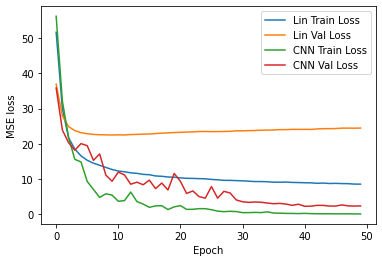

In [22]:
#  plot loss
lin_data_label = list(zip([tl_lin2,vl_lin2,tl_cnn, vl_cnn], 
                          ['Lin Train Loss','Lin Val Loss', 'CNN Train Loss','CNN Val Loss']))
quick_loss_plot(lin_data_label)

## inspect CNN model...?

In [23]:
model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [24]:
ch = list(model_cnn.conv_net.children())

In [25]:
ch[0].weight.shape

torch.Size([32, 4, 3])

In [26]:
list(ch[0].children())

[]

In [27]:
model_children = list(model_cnn.children())

In [28]:
model_children

[Sequential(
   (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
   (1): ReLU(inplace=True)
   (2): Flatten(start_dim=1, end_dim=-1)
   (3): Linear(in_features=128, out_features=10, bias=True)
   (4): ReLU(inplace=True)
   (5): Linear(in_features=10, out_features=1, bias=True)
 )]

In [29]:
# counter to keep count of the conv layers
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    print(type(model_children[i]))
    if type(model_children[i]) == nn.Conv1d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    
    elif type(model_children[i]) == nn.Sequential:
        for child in model_children[i]:
            print(child)
            if type(child) == nn.Conv1d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

<class 'torch.nn.modules.container.Sequential'>
Conv1d(4, 32, kernel_size=(3,), stride=(1,))
ReLU(inplace=True)
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=128, out_features=10, bias=True)
ReLU(inplace=True)
Linear(in_features=10, out_features=1, bias=True)
Total convolutional layers: 1


In [30]:
conv_layers

[Conv1d(4, 32, kernel_size=(3,), stride=(1,))]

In [31]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

WEIGHT: Parameter containing:
tensor([[[ 0.3662, -0.5362,  0.2634],
         [-0.3756,  0.0659, -0.2384],
         [ 0.1228,  0.2166, -0.2926],
         [-0.3275,  0.3516,  0.1297]],

        [[-0.0798, -0.2572, -0.1539],
         [ 0.1709, -0.1131,  0.2211],
         [ 0.1692, -0.0018,  0.0310],
         [-0.2129,  0.1450, -0.2054]],

        [[-0.0741,  0.0348, -0.3713],
         [-0.0793, -0.0456, -0.1995],
         [-0.1531, -0.0375,  0.3376],
         [ 0.1806,  0.3669, -0.0473]],

        [[-0.1928, -0.0606, -0.2551],
         [ 0.2874,  0.1965, -0.2208],
         [ 0.1589,  0.1411,  0.1693],
         [-0.0723, -0.2026,  0.1783]],

        [[ 0.1291, -0.1899, -0.1421],
         [-0.2484,  0.0780, -0.2855],
         [-0.3069, -0.0298,  0.0586],
         [-0.3233, -0.0160,  0.1610]],

        [[-0.1054,  0.1976, -0.1496],
         [-0.0518, -0.2451, -0.2842],
         [ 0.1685,  0.3183,  0.3140],
         [ 0.0263, -0.5196,  0.3672]],

        [[-0.0310,  0.3146, -0.1374],
        

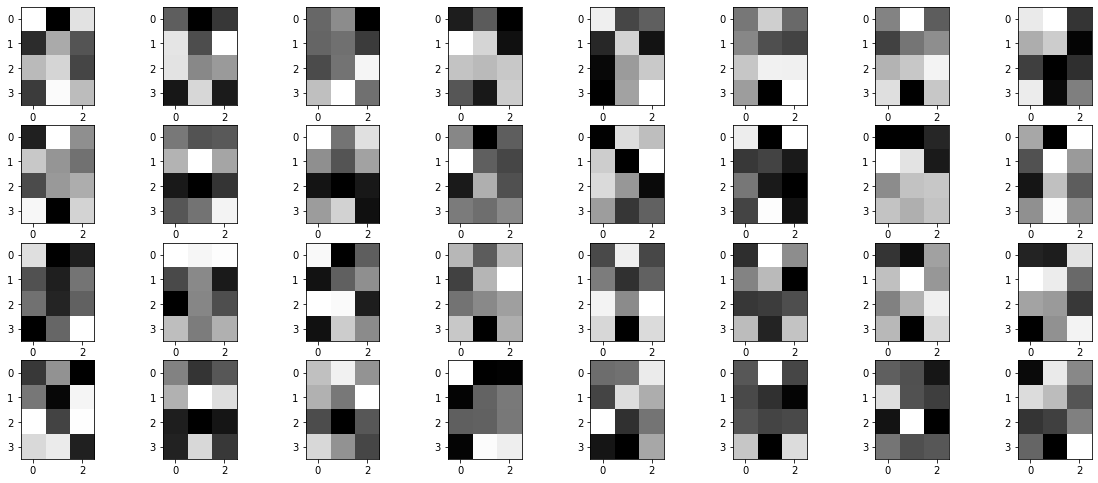

In [32]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter.detach(), cmap='gray')
    #plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()

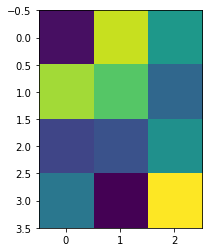

In [33]:
plt.imshow(filter.detach())

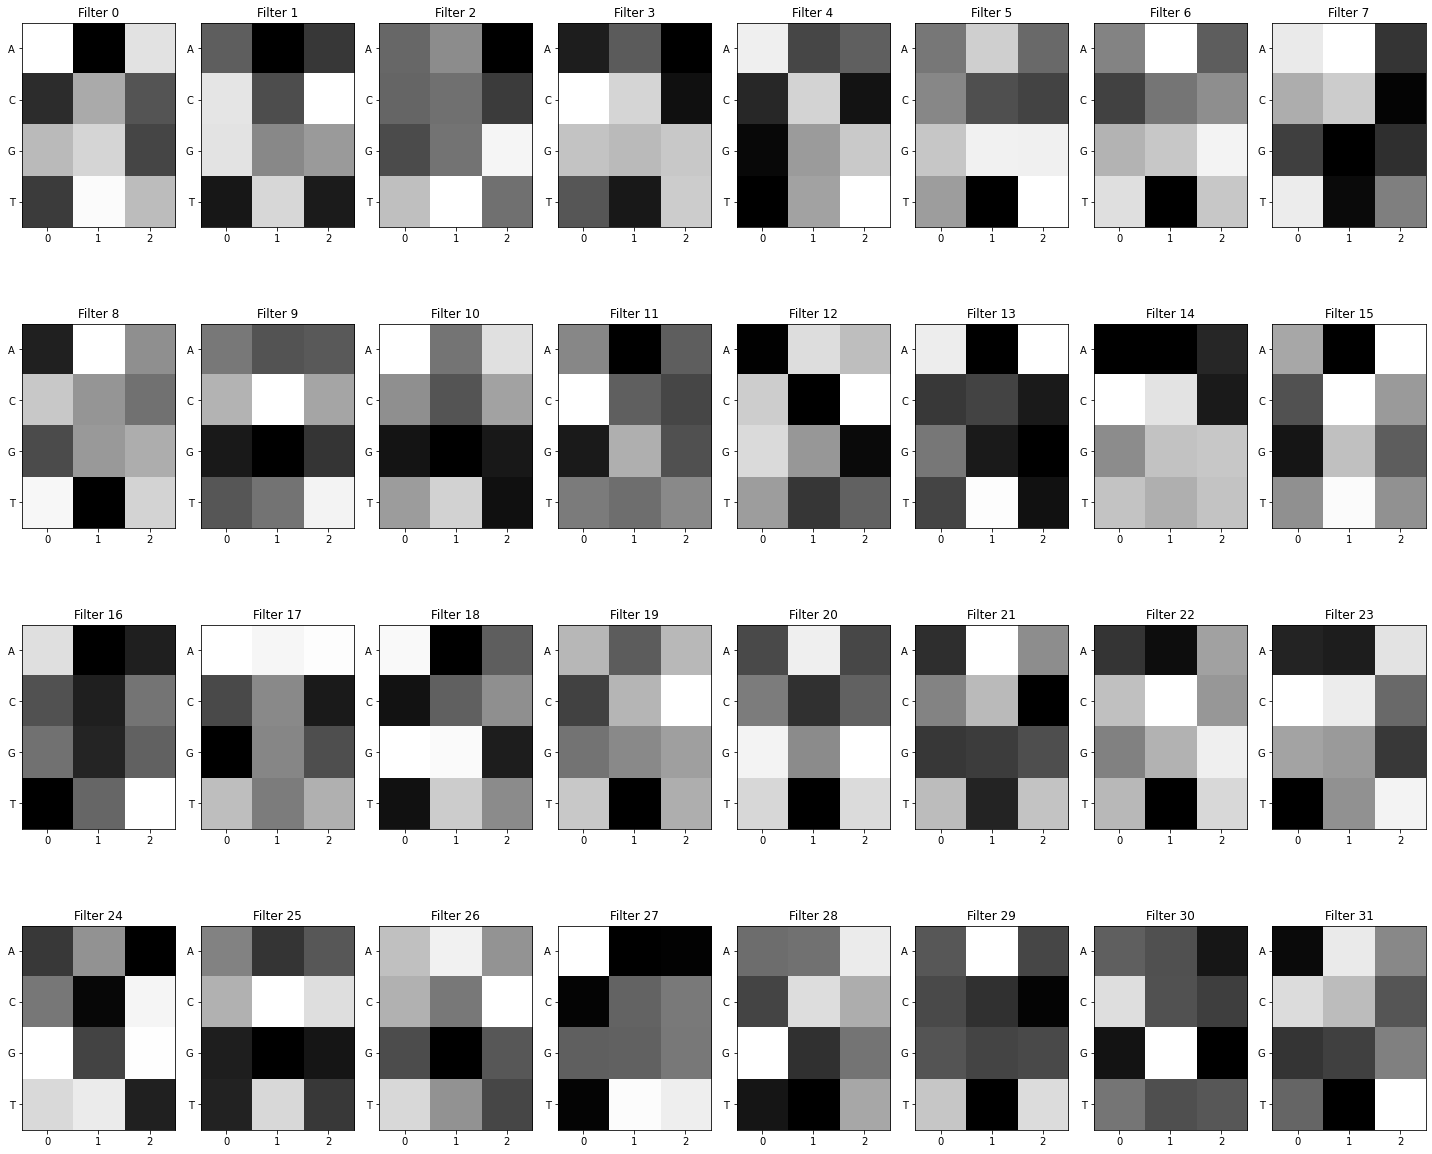

In [45]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))

for i, filter in enumerate(model_weights[0]):
    #fig,ax = plt.subplots() # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    ax = plt.subplot(4, 8, i+1)
    ax.imshow(filter.detach(), cmap='gray')
    #locs, labels = yticks()
    ax.set_yticks(np.arange(4))
    ax.set_yticklabels(['A', 'C', 'G','T'])
    ax.set_xticks(np.arange(3))
    ax.set_title(f"Filter {i}")
    
    
    #plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.tight_layout()
plt.show()

In [137]:
print(filter)
for row in filter.T:
    print(argmax(row))

tensor([[ 0.2481, -0.2587, -0.0126],
        [-0.0811, -0.1232, -0.2562],
        [ 0.2222, -0.0216, -0.2759],
        [-0.2879, -0.1916,  0.2354]], grad_fn=<UnbindBackward>)


NameError: name 'argmax' is not defined

In [46]:
fig,ax = plt.figure(figsize=(20, 17))
#ax = plt.subplot(8, 8, i+1)

filt_df = pd.DataFrame(filter.T.detach().numpy(),columns=['A','C','G','T'])
logo1 = logomaker.transform_matrix(filt_df,from_type='weight',to_type='information')
crp_logo1 = logomaker.Logo(logo1,ax=ax)

TypeError: cannot unpack non-iterable Figure object

<Figure size 1440x1224 with 0 Axes>

(0.0, 2.0)

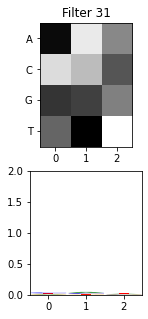

In [53]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=[2,5])

ax1.imshow(filter.detach(), cmap='gray')
ax1.set_yticks(np.arange(4))
ax1.set_yticklabels(['A', 'C', 'G','T'])
ax1.set_xticks(np.arange(3))
ax1.set_title(f"Filter {i}")

filt_df = pd.DataFrame(filter.T.detach().numpy(),columns=['A','C','G','T'])
logo1 = logomaker.transform_matrix(filt_df,from_type='weight',to_type='information')
crp_logo1 = logomaker.Logo(logo1,ax=ax2)
ax2.set_ylim(0,2)


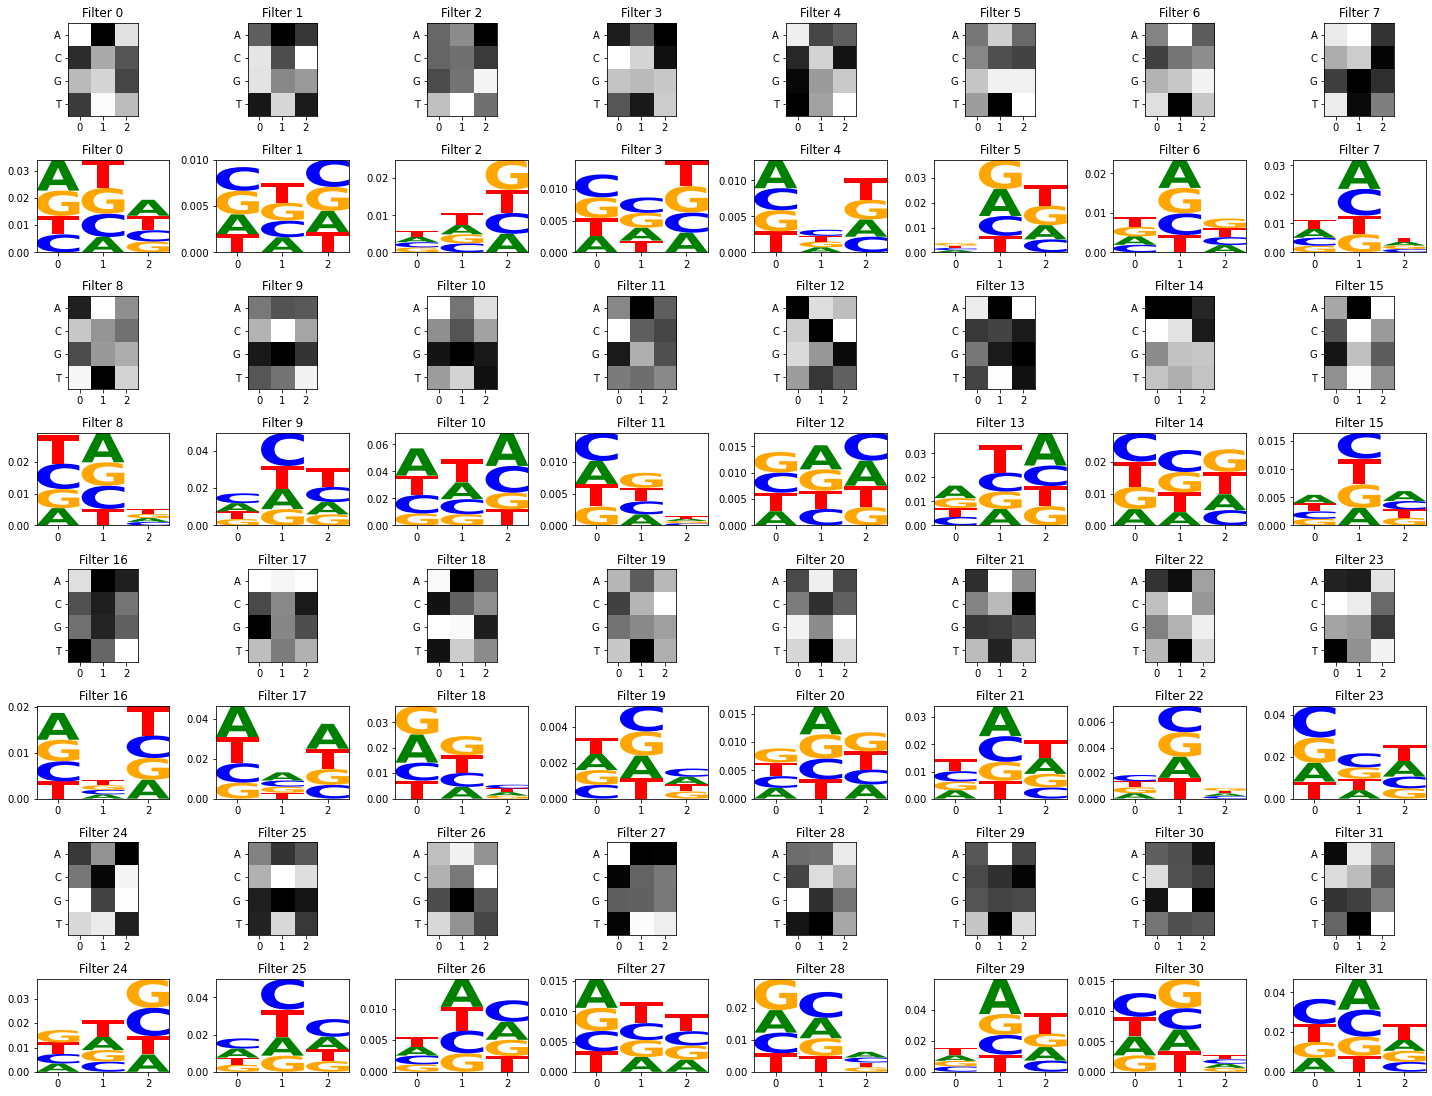

In [75]:
plt.figure(figsize=(20, 17))

j=0
for i, filter in enumerate(model_weights[0]):
    if (i)%8 == 0:
        j += 8
#     print('i:', i)
#     print('j:', j)
#     print('i%8 == 0', i%8 == 0)
# #     print('i+1%9 =?', (i+1)%9)
#     print("i+j+1=", i+j+1)
#     print("i+j+1+4=", i+j+1+8)
#     print("*******")
    
    #fig,ax = plt.subplots() # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    ax1 = plt.subplot(9, 8, i+j+1)
    ax1.imshow(filter.detach(), cmap='gray')
    ax1.set_yticks(np.arange(4))
    ax1.set_yticklabels(['A', 'C', 'G','T'])
    ax1.set_xticks(np.arange(3))
    ax1.set_title(f"Filter {i}")
    
    
    ax2 = plt.subplot(9, 8, i+j+1+8)
    filt_df = pd.DataFrame(filter.T.detach().numpy(),columns=['A','C','G','T'])
    logo1 = logomaker.transform_matrix(filt_df,from_type='weight',to_type='information')
    crp_logo1 = logomaker.Logo(logo1,ax=ax2)
    #ax2.set_ylim(0,2)
    ax2.set_title(f"Filter {i}")
    
plt.tight_layout()


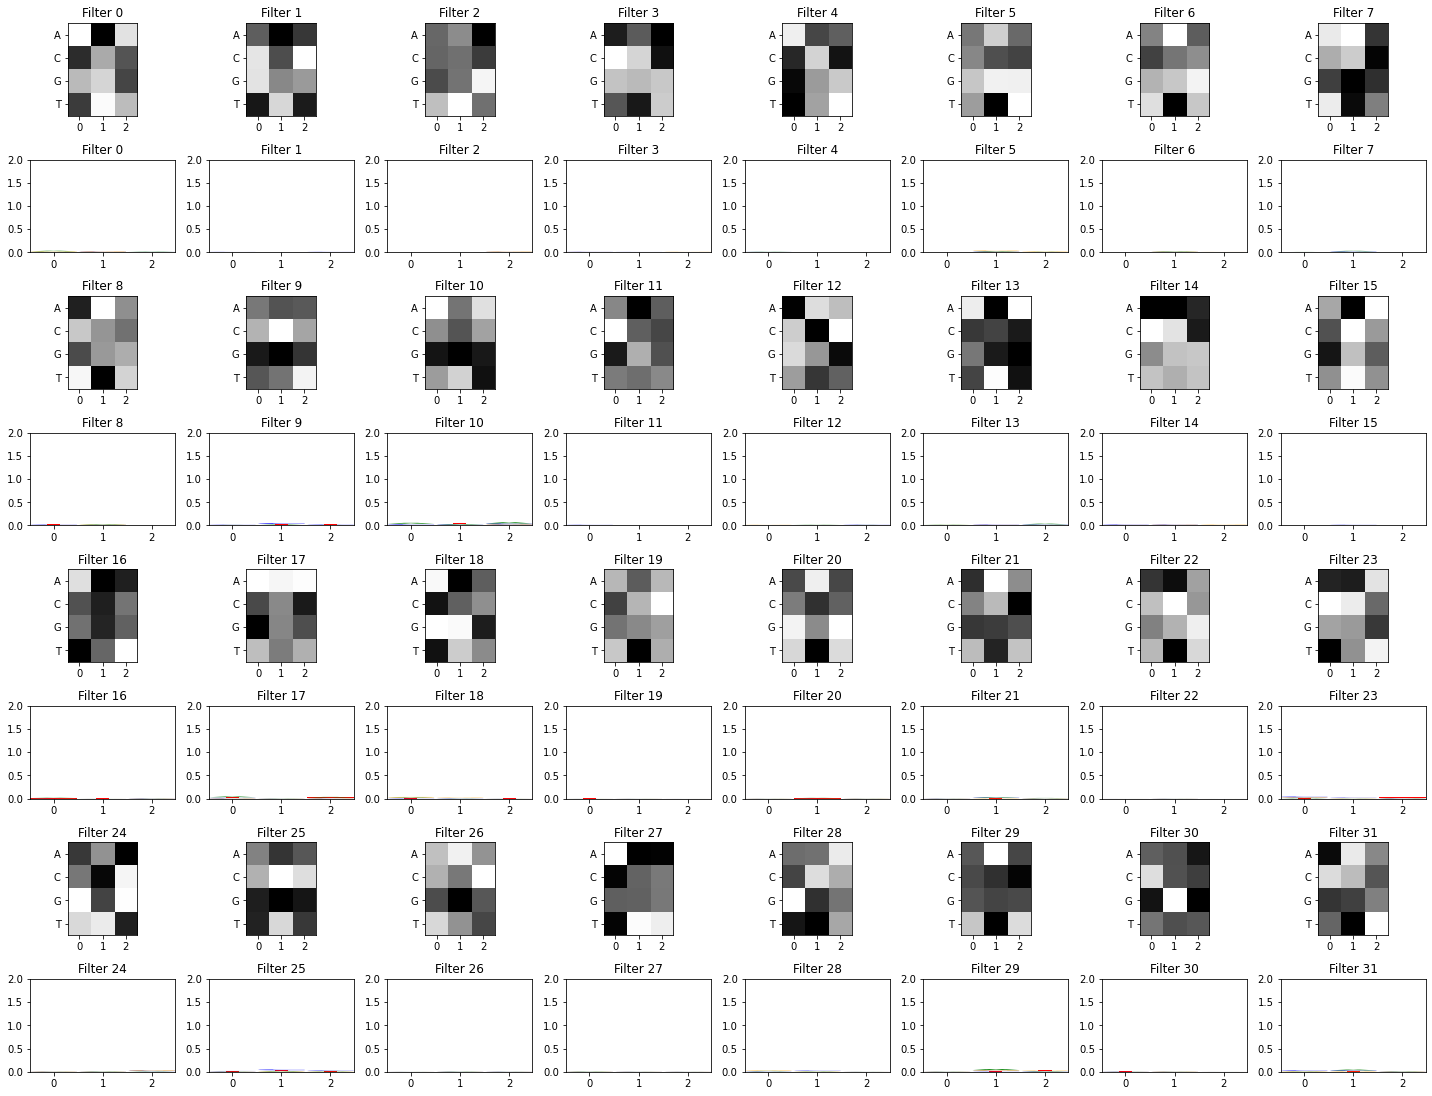

In [76]:
plt.figure(figsize=(20, 17))

j=0
for i, filter in enumerate(model_weights[0]):
    if (i)%8 == 0:
        j += 8
#     print('i:', i)
#     print('j:', j)
#     print('i%8 == 0', i%8 == 0)
# #     print('i+1%9 =?', (i+1)%9)
#     print("i+j+1=", i+j+1)
#     print("i+j+1+4=", i+j+1+8)
#     print("*******")
    
    #fig,ax = plt.subplots() # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    ax1 = plt.subplot(9, 8, i+j+1)
    ax1.imshow(filter.detach(), cmap='gray')
    ax1.set_yticks(np.arange(4))
    ax1.set_yticklabels(['A', 'C', 'G','T'])
    ax1.set_xticks(np.arange(3))
    ax1.set_title(f"Filter {i}")
    
    
    ax2 = plt.subplot(9, 8, i+j+1+8)
    filt_df = pd.DataFrame(filter.T.detach().numpy(),columns=['A','C','G','T'])
    logo1 = logomaker.transform_matrix(filt_df,from_type='weight',to_type='information')
    crp_logo1 = logomaker.Logo(logo1,ax=ax2)
    ax2.set_ylim(0,2)
    ax2.set_title(f"Filter {i}")
    
plt.tight_layout()


In [43]:
filt_df

,A,C,G,T
0,-0.498204,0.343240,-0.324301,-0.134048
1,0.398532,0.213323,-0.279998,-0.539613
2,0.005433,-0.198585,-0.025666,0.484422


In [ ]:
def view_motif(m1,m2):
    '''
    Given two Motif objects from the BioPython motifs module,
    create a sequence logo from their PWMs
    '''
    df1 = pd.DataFrame(m1.pwm, columns=['A','C','G','T'])
    df2 = pd.DataFrame(m2.pwm, columns=['A','C','G','T'])

    # initialize 2 panel figure
    fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=[10,2])

    # block 1
    logo1 = logomaker.transform_matrix(df1,from_type='probability',to_type='information')
    crp_logo1 = logomaker.Logo(logo1,ax=ax1)

    # block 2
    logo2 = logomaker.transform_matrix(df2,from_type='probability',to_type='information')
    crp_logo2 = logomaker.Logo(logo2,ax=ax2,)

    # labels
    df1_title = f"Motif Block 1"
    df2_title = f"Motif Block 2"
    ax1.set_title(df1_title)
    ax2.set_title(df2_title)
    ax1.set_xticks([])
    ax2.set_xticks([])

    plt.ylim(0,2)

    plt.show()

In [35]:
# train test split
idxs = list(range(df.shape[0]))
random.shuffle(idxs)
print(idxs)

split = int(len(idxs)*0.8)
train_idxs = idxs[:split]
test_idxs = idxs[split:]

print("Train #:", len(train_idxs))
print("Test #:", len(test_idxs))

[17, 1, 21, 11, 44, 42, 48, 12, 15, 20, 39, 19, 43, 36, 37, 7, 40, 18, 30, 25, 33, 45, 38, 32, 23, 10, 14, 16, 24, 13, 27, 41, 8, 31, 29, 46, 9, 5, 22, 3, 4, 34, 47, 0, 2, 26, 6, 28, 35]
Train #: 39
Test #: 10


In [36]:
train_df = df[df.index.isin(train_idxs)]
test_df = df[df.index.isin(test_idxs)]

x_train = torch.tensor(list(train_df['oh'].values))
y_train = torch.tensor(list(train_df['score'].values)).unsqueeze(1)
x_test  = torch.tensor(list(test_df['oh'].values))
y_test  = torch.tensor(list(test_df['score'].values)).unsqueeze(1)

print(x_test)
print(y_test)

tensor([[1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,

In [37]:
bs = 4

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs * 2)

lr = 0.01
epochs = 50
model_lin2 = DNA_Linear()
loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model_lin2.parameters(), lr=lr)

In [39]:
tl_lin2, vl_lin2 = fit(50, model_lin2, loss_func, optimizer, train_dl, test_dl)

0 68.09041748046874
1 49.32786865234375
2 39.55677337646485
3 34.41413192749023
4 31.67222671508789
5 30.251473236083985
6 29.120285034179688
7 28.075050354003906
8 26.81099090576172
9 25.930934143066406
10 25.401055908203126
11 24.998995971679687
12 25.110486602783205
13 25.0474494934082
14 24.43956604003906
15 24.374861907958984
16 24.2609619140625
17 23.6954833984375
18 23.551791381835937
19 23.70868377685547
20 23.182360076904295
21 22.983940887451173
22 23.02279052734375
23 22.964396667480468
24 22.60875244140625
25 22.514385223388672
26 22.417697143554687
27 22.417207336425783
28 22.191029357910157
29 22.35784454345703
30 22.562381744384766
31 21.928821563720703
32 21.614825439453124
33 21.706591033935545
34 21.803601837158205
35 21.727206420898437
36 21.717665100097655
37 21.62573699951172
38 21.69854736328125
39 21.549234771728514
40 21.34781494140625
41 21.128070068359374
42 21.394181060791016
43 21.207501220703126
44 21.21027603149414
45 21.303125
46 21.293035888671874
47 21.

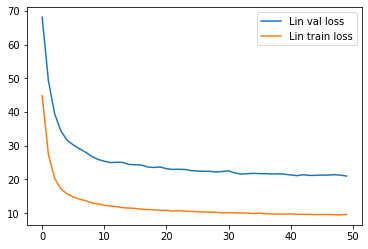

In [40]:
plt.plot(vl_lin2, label="Lin val loss")
plt.plot(tl_lin2, label="Lin train loss")
plt.legend()
plt.show()

In [42]:
for dna in ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_lin2(s.float())
    print(dna, pred)

AAAAAA tensor([11.7176], grad_fn=<AddBackward0>)
CCCCCC tensor([5.2495], grad_fn=<AddBackward0>)
GGGGGG tensor([0.4521], grad_fn=<AddBackward0>)
TTTTTT tensor([5.0028], grad_fn=<AddBackward0>)
AACCAA tensor([5.2514], grad_fn=<AddBackward0>)
CCGGGG tensor([0.3986], grad_fn=<AddBackward0>)
GGGTAA tensor([4.0127], grad_fn=<AddBackward0>)
TTTCGT tensor([3.2138], grad_fn=<AddBackward0>)
TGTAAT tensor([10.3386], grad_fn=<AddBackward0>)


In [44]:
for dna in :
    s = torch.tensor(one_hot_encode(dna))
    pred = model_lin2(s.float())
    print(dna, pred)
    
#     ('TATAAA', 14.9),
#     ('TAATAT', 14.8),
#     ('CCTATA', 14.5),
#     ('AAGCGA', 0.6),
#     ('GCGAAA', 0.7),
#     ('TTGCGA', 0.2),


TATAAA tensor([10.8625], grad_fn=<AddBackward0>)
TAATAT tensor([8.9638], grad_fn=<AddBackward0>)
CCTATA tensor([9.1524], grad_fn=<AddBackward0>)
AAGCGA tensor([3.5378], grad_fn=<AddBackward0>)
GCGAAA tensor([6.5253], grad_fn=<AddBackward0>)
TTGCGA tensor([-0.2992], grad_fn=<AddBackward0>)
GCGTAA tensor([3.7381], grad_fn=<AddBackward0>)
TATTAA tensor([8.0753], grad_fn=<AddBackward0>)
TTTATT tensor([7.7900], grad_fn=<AddBackward0>)


In [45]:
# class DNA_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv_net = nn.Sequential(
#             nn.Conv1d(4, 10, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(10,10, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.Sigmoid()) # ?? Linear?

#     def forward(self, xb):
#         xb = xb.view(-1,6,4) # reshape to 4x6
#         xb = self.conv_net(xb)
#         return xb
    
# class DNA_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv_net = nn.Sequential(
#             nn.Conv1d(4, 16, kernel_size=(3,1)),
#             nn.ReLU(inplace=True),
#             nn.Linear(96, 1)) # ?? Linear?

#     def forward(self, xb):
#         xb = xb.view(-1,6,4) # reshape to 4x6
#         xb = self.conv_net(xb)
#         return xb

class DNA_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) # ?? Linear?

    def forward(self, xb):
        xb = xb.view(-1,6,4).permute(0,2,1) # reshape to 4bs x 4channel x 6len
        #print(xb)
        xb = self.conv_net(xb)
        return xb
    
# class DNA_Linear(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lin = nn.Linear(24, 1)

#     def forward(self, xb):
#         # lin wraps up the weights/bias dot product from before
#         return self.lin(xb)

In [46]:
model_cnn = DNA_CNN()
loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=lr)
tl_cnn, vl_cnn = fit(50, model_cnn, loss_func, optimizer, train_dl, test_dl)

0 40.6715690612793
1 40.37783660888672
2 36.810550689697266
3 25.871519470214842
4 40.83929290771484
5 39.22800521850586
6 77.48642578125
7 27.12381362915039
8 18.393498992919923
9 17.6382194519043
10 20.524129486083986
11 21.57399215698242
12 12.914355850219726
13 11.953047943115234
14 15.0128662109375
15 12.581398391723633
16 11.565887451171875
17 6.693359756469727
18 7.235995483398438
19 7.864342117309571
20 5.465847778320312
21 7.203878021240234
22 4.886105346679687
23 4.112865829467774
24 4.8013715744018555
25 4.102758407592773
26 3.7902560234069824
27 3.8833343505859377
28 4.053083038330078
29 4.585363388061523
30 3.3617820739746094
31 3.3483532905578612
32 3.388096809387207
33 3.782131385803223
34 3.442391204833984
35 4.611374568939209
36 3.4518901824951174
37 2.7605968475341798
38 2.6472429990768434
39 2.632403039932251
40 2.490719938278198
41 2.4544651031494142
42 3.0625499725341796
43 2.4440274238586426
44 2.463066816329956
45 2.217893123626709
46 2.2091307163238527
47 2.5803

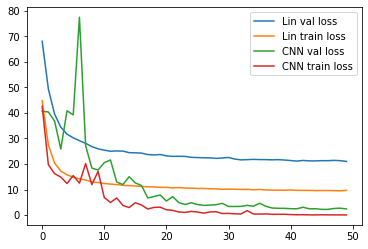

In [47]:
plt.plot(vl_lin2, label="Lin val loss")
plt.plot(tl_lin2, label="Lin train loss")
plt.plot(vl_cnn, label="CNN val loss")
plt.plot(tl_cnn, label="CNN train loss")
plt.legend()
plt.show()

In [48]:
for dna in ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_cnn(s.float())
    print(dna, pred)

AAAAAA tensor([[9.2661]], grad_fn=<AddmmBackward>)
CCCCCC tensor([[7.0220]], grad_fn=<AddmmBackward>)
GGGGGG tensor([[3.8047]], grad_fn=<AddmmBackward>)
TTTTTT tensor([[1.0482]], grad_fn=<AddmmBackward>)
AACCAA tensor([[4.8595]], grad_fn=<AddmmBackward>)
CCGGGG tensor([[3.0401]], grad_fn=<AddmmBackward>)
GGGTAA tensor([[8.0723]], grad_fn=<AddmmBackward>)
TTTCGT tensor([[1.2749]], grad_fn=<AddmmBackward>)
TGTAAT tensor([[12.7573]], grad_fn=<AddmmBackward>)


In [50]:
for dna in ['TATAAA', 'TAATAT','CCTATA','AAGCGA','GCGAAA','TTGCGA','GCGTAA', 'TATTAA','TTTATT']:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_cnn(s.float())
    print(dna, pred)
    
#     ('TATAAA', 14.9),
#     ('TAATAT', 14.8),
#     ('CCTATA', 14.5),
#     ('AAGCGA', 0.6),
#     ('GCGAAA', 0.7),
#     ('TTGCGA', 0.2),


TATAAA tensor([[15.1144]], grad_fn=<AddmmBackward>)
TAATAT tensor([[14.6269]], grad_fn=<AddmmBackward>)
CCTATA tensor([[11.5350]], grad_fn=<AddmmBackward>)
AAGCGA tensor([[0.4359]], grad_fn=<AddmmBackward>)
GCGAAA tensor([[1.0538]], grad_fn=<AddmmBackward>)
TTGCGA tensor([[0.3293]], grad_fn=<AddmmBackward>)
GCGTAA tensor([[3.9840]], grad_fn=<AddmmBackward>)
TATTAA tensor([[14.5705]], grad_fn=<AddmmBackward>)
TTTATT tensor([[13.7654]], grad_fn=<AddmmBackward>)


In [61]:
print(xb.view(-1,1,6,4))
print(xb.view(-1,6,4))

tensor([[[[1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.]]]], dtype=torch.float64)
tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0.

In [79]:
xb.view(-1,4)

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)

In [82]:
xb.shape

torch.Size([4, 24])

In [84]:
xb[0].shape

torch.Size([24])

In [89]:
xb.view(4,6,4)

tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]]], dtype=torch.float64)

In [91]:
xb.view(-1,6,4) == xb.view(4,6,4)

tensor([[[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]])

In [117]:
xb.view(4,4,6).shape

torch.Size([4, 4, 6])

In [124]:
xb.view(-1,6,4).permute(0,2,1)

tensor([[[1., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 1.],
         [1., 1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 1., 1.],
         [0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]], dtype=torch.float64)

In [125]:
xb.view(-1,6,4).permute(0,2,1).shape

torch.Size([4, 4, 6])

In [ ]:
xb = x_train[0:bs]  # a mini-batch from x
preds = model_lin(xb.float()) 